In [1]:
from sklearn.model_selection import KFold, GridSearch


# 1. Functions for metrics

In [21]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
# def gini_normalized(model,X,y):
#     y_pred=model.predict(X)
#     return gini(y,y_pred)/gini(y,y)
def gini_coefficient(preds,dtrain):
    y = dtrain.get_label()
    return 'gini', -gini_normalized(y,preds)

# 2. Custom class for Grid cv Search

In [35]:


class CustomGridCV(object):
    def __init__(self, X, y, model, metric, griddata, cv=3):
        self.X = X
        self.y = y
        self.model = model
        self.metric = metric
        self.params = self.gridpoints(griddata)
        self.cv = cv
        self.bestScore = None
        self.bestParams = None
        
    def gridpoints(self, data):
        newparams = [{}]
        for k in data.keys():
            params = newparams
            newparams = []
            for v in data[k]:
                for param in params:
                    item = param.copy()
                    item[k]=v
                    newparams.append(item)           
        return newparams
    
    def GridSearch(self):
        for param in self.params:
            self.model.set_params(**param)
            score = self.KFoldScore()
            if self.bestScore==None or self.bestScore<score:
                self.bestScore = score
                self.bestParams = param
            print("Score: {0:.5f}, Params: {1}".format(score,param))
    
    def KFoldScore(self):
        kf = KFold(n_splits=5, shuffle=True)
        y_pred = np.zeros(len(self.y))

        for train_index, test_index in kf.split(self.X):
            train_X, test_X = self.X[train_index], self.X[test_index]
            train_y, test_y = self.y[train_index], self.y[test_index]
            self.model.fit(train_X,train_y)
            y_pred[test_index] = self.model.predict_proba(test_X)[:,1]

        return self.metric(self.y,y_pred)

   
    
    def Best(self):
        return self.bestScore, self.bestParams

# 3. Data Preparation 
### Add your feature engineering work here

In [23]:
import pandas as pd
import numpy as np

def PrepareData(trainpath,nrows=None):
    df = pd.read_csv(trainpath, index_col='id',nrows=nrows)

    features = list(df.columns)
    target = 'target'
    features.remove(target)

    X = np.array(df[features])
    y = np.array(df[target])
    return X, y

In [24]:
X,y=PrepareData('data/train.csv',nrows=10000);

# 4. Search for the best hyperparameters
## 4.1 The whole hyperparameter space is huge, we are not able to search the whole space
## 4.2 We don't have to use all the data for hyperparameter searching. Tune nrows to determine the size of data considered. Have a look at learning curve.

In [64]:
from sklearn.ensemble import RandomForestClassifier


# Select a Model
model = RandomForestClassifier(oob_score=True)

# # Set the ranges for parameters
griddata = {"n_estimators":range(230,301,10),
            #"min_samples_split": range(24,25),
            
             }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.17671, Params: {'n_estimators': 230}
Score: 0.17996, Params: {'n_estimators': 240}
Score: 0.17950, Params: {'n_estimators': 250}
Score: 0.16216, Params: {'n_estimators': 260}
Score: 0.17721, Params: {'n_estimators': 270}
Score: 0.21351, Params: {'n_estimators': 280}
Score: 0.16768, Params: {'n_estimators': 290}
Score: 0.18782, Params: {'n_estimators': 300}
Best Params:
(0.21350914706972071, {'n_estimators': 280})


In [65]:
# # Set the ranges for parameters
griddata = {"n_estimators":range(280,290,1),
            #"min_samples_split": range(24,25),
            
             }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.20105, Params: {'n_estimators': 280}
Score: 0.21523, Params: {'n_estimators': 281}
Score: 0.20448, Params: {'n_estimators': 282}
Score: 0.19620, Params: {'n_estimators': 283}
Score: 0.18843, Params: {'n_estimators': 284}
Score: 0.16862, Params: {'n_estimators': 285}
Score: 0.21920, Params: {'n_estimators': 286}
Score: 0.20852, Params: {'n_estimators': 287}
Score: 0.20396, Params: {'n_estimators': 288}
Score: 0.20606, Params: {'n_estimators': 289}
Best Params:
(0.21920414309178002, {'n_estimators': 286})


In [66]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=289, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

# Choose the n_estimator to be 286, next let us tune mex_features

In [68]:
# # Set the ranges for parameters
griddata = {"n_estimators":range(286,287),
            "max_features": range(5,51,5)
            
             }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.21402, Params: {'n_estimators': 286, 'max_features': 5}
Score: 0.18741, Params: {'n_estimators': 286, 'max_features': 10}
Score: 0.20210, Params: {'n_estimators': 286, 'max_features': 15}
Score: 0.19363, Params: {'n_estimators': 286, 'max_features': 20}
Score: 0.18262, Params: {'n_estimators': 286, 'max_features': 25}
Score: 0.19148, Params: {'n_estimators': 286, 'max_features': 30}
Score: 0.18999, Params: {'n_estimators': 286, 'max_features': 35}
Score: 0.17101, Params: {'n_estimators': 286, 'max_features': 40}
Score: 0.17317, Params: {'n_estimators': 286, 'max_features': 45}
Score: 0.17015, Params: {'n_estimators': 286, 'max_features': 50}
Best Params:
(0.21401814796623161, {'n_estimators': 286, 'max_features': 5})


In [ ]:
# The result shows that 'max_features'=5 is the best parameter. Let us take a closer look of 
# interval [5,10] with stepsize=1

In [69]:
# # Set the ranges for parameters
griddata = {"n_estimators":range(286,287),
            "max_features": range(5,11)
                       }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.17225, Params: {'n_estimators': 286, 'max_features': 5}
Score: 0.18013, Params: {'n_estimators': 286, 'max_features': 6}
Score: 0.19758, Params: {'n_estimators': 286, 'max_features': 7}
Score: 0.19945, Params: {'n_estimators': 286, 'max_features': 8}
Score: 0.20840, Params: {'n_estimators': 286, 'max_features': 9}
Score: 0.23637, Params: {'n_estimators': 286, 'max_features': 10}
Best Params:
(0.23636592008631074, {'n_estimators': 286, 'max_features': 10})


In [ ]:
# Now we determine the value for two paras, namely 'n_estimators'= 286, 'max_features'=10.
# Next we will fix those two parameters and tune parameter 'max_depth'

In [71]:
griddata = {"n_estimators":range(286,287),
            "max_features": range(10,11),
             "max_depth": range(1,10)          }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.21628, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 1}
Score: 0.22421, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 2}
Score: 0.24416, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 3}
Score: 0.24511, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 4}
Score: 0.23439, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 5}
Score: 0.22787, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 6}
Score: 0.20954, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 7}
Score: 0.23330, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 8}
Score: 0.21716, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 9}
Best Params:
(0.24510504862521765, {'n_estimators': 286, 'max_features': 10, 'max_depth': 4})


In [ ]:
# Let us try a different strategy by combining the max_features and max_depth, see what is best 
# combination for those two paras

In [72]:
griddata = {"n_estimators":range(286,287),
            "max_features": range(5,11),
             "max_depth": range(1,10)          }

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.19519, Params: {'n_estimators': 286, 'max_features': 5, 'max_depth': 1}
Score: 0.21209, Params: {'n_estimators': 286, 'max_features': 6, 'max_depth': 1}
Score: 0.23056, Params: {'n_estimators': 286, 'max_features': 7, 'max_depth': 1}
Score: 0.16929, Params: {'n_estimators': 286, 'max_features': 8, 'max_depth': 1}
Score: 0.21036, Params: {'n_estimators': 286, 'max_features': 9, 'max_depth': 1}
Score: 0.21937, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 1}
Score: 0.23717, Params: {'n_estimators': 286, 'max_features': 5, 'max_depth': 2}
Score: 0.24036, Params: {'n_estimators': 286, 'max_features': 6, 'max_depth': 2}
Score: 0.21066, Params: {'n_estimators': 286, 'max_features': 7, 'max_depth': 2}
Score: 0.21757, Params: {'n_estimators': 286, 'max_features': 8, 'max_depth': 2}
Score: 0.23425, Params: {'n_estimators': 286, 'max_features': 9, 'max_depth': 2}
Score: 0.22208, Params: {'n_estimators': 286, 'max_features': 10, 'max_depth': 2}
Score: 0.22739, Params: {'

In [81]:
griddata = {"n_estimators":range(286,400,10),
            "max_features": range(5,6),
             "max_depth": range(5,6)}

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.23110, Params: {'n_estimators': 286, 'max_features': 5, 'max_depth': 5}
Score: 0.24468, Params: {'n_estimators': 296, 'max_features': 5, 'max_depth': 5}
Score: 0.23173, Params: {'n_estimators': 306, 'max_features': 5, 'max_depth': 5}
Score: 0.22825, Params: {'n_estimators': 316, 'max_features': 5, 'max_depth': 5}
Score: 0.23545, Params: {'n_estimators': 326, 'max_features': 5, 'max_depth': 5}
Score: 0.24500, Params: {'n_estimators': 336, 'max_features': 5, 'max_depth': 5}
Score: 0.23071, Params: {'n_estimators': 346, 'max_features': 5, 'max_depth': 5}
Score: 0.23453, Params: {'n_estimators': 356, 'max_features': 5, 'max_depth': 5}
Score: 0.22720, Params: {'n_estimators': 366, 'max_features': 5, 'max_depth': 5}
Score: 0.22569, Params: {'n_estimators': 376, 'max_features': 5, 'max_depth': 5}
Score: 0.22809, Params: {'n_estimators': 386, 'max_features': 5, 'max_depth': 5}
Score: 0.24332, Params: {'n_estimators': 396, 'max_features': 5, 'max_depth': 5}
Best Params:
(0.244996995633

In [82]:
griddata = {"n_estimators":range(296,330,2),
            "max_features": range(5,6),
             "max_depth": range(5,6)}

# Grid Search for the best parameters
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)

GCV.GridSearch()

print("Best Params:")
print(GCV.Best())

Score: 0.22999, Params: {'n_estimators': 296, 'max_features': 5, 'max_depth': 5}
Score: 0.23417, Params: {'n_estimators': 298, 'max_features': 5, 'max_depth': 5}
Score: 0.24705, Params: {'n_estimators': 300, 'max_features': 5, 'max_depth': 5}
Score: 0.22964, Params: {'n_estimators': 302, 'max_features': 5, 'max_depth': 5}
Score: 0.23070, Params: {'n_estimators': 304, 'max_features': 5, 'max_depth': 5}
Score: 0.23742, Params: {'n_estimators': 306, 'max_features': 5, 'max_depth': 5}
Score: 0.23281, Params: {'n_estimators': 308, 'max_features': 5, 'max_depth': 5}
Score: 0.26397, Params: {'n_estimators': 310, 'max_features': 5, 'max_depth': 5}
Score: 0.24213, Params: {'n_estimators': 312, 'max_features': 5, 'max_depth': 5}
Score: 0.24508, Params: {'n_estimators': 314, 'max_features': 5, 'max_depth': 5}
Score: 0.23657, Params: {'n_estimators': 316, 'max_features': 5, 'max_depth': 5}
Score: 0.22714, Params: {'n_estimators': 318, 'max_features': 5, 'max_depth': 5}
Score: 0.26344, Params: {'n_

# Best Params:(for first stacking)
# (0.2728477914544345, {'n_estimators': 230, 'min_samples_split': 14, 'min_samples_leaf': 20})
# valid error for all data: 0.257

# Use Bayesian Optimization to tune hyper parameter 

In [52]:
from __future__ import print_function
from __future__ import division
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization

In [53]:
# # Read Data
trainpath = "data/train.csv"
X, y = PrepareData(trainpath,nrows=10000)

In [114]:
# read all data
trainpath = "data/train.csv"
X_all, y_all = PrepareData(trainpath)
X_all.shape

(595212, 57)

In [54]:
# The function used in most kernels 
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return gini(a, p) / gini(a, a)

In [55]:
def gini_sklearn(model,X,y):
    y_pred=model.predict_proba(X)[:,1]
    return gini(y,y_pred)/gini(y,y)    

In [56]:
# Faster Gini calculation https://www.kaggle.com/tezdhar/faster-gini-calculation
from sklearn import metrics
#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)
gini_sklearnf = metrics.make_scorer(gini_normalizedc, True, True)

In [115]:
def rfccv(n_estimators, max_features, max_depth):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            #min_samples_split=int(min_samples_split),
            max_features=int(max_features),
            max_depth=int(max_depth),
            random_state=None),
        X_all, y_all, scoring=gini_sklearnf, cv=3
    ).mean()
    return val

In [118]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,301),
         'max_features': (5,10),
         'max_depth': (1,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 14m25s |    0.26116 |      9.6396 |         9.5403 |       300.6631 | 
    2 | 09m42s |    0.26109 |      9.4689 |         6.6422 |       300.7091 | 
    3 | 03m36s |    0.24106 |      3.3649 |         6.3630 |       300.2959 | 
    4 | 13m48s |    0.26088 |      9.7031 |         9.7045 |       300.6985 | 
    5 | 07m50s |    0.24950 |      5.9687 |         8.3182 |       300.9603 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 10m16s |    0.26151 |     10.0000 |         5.0000 |       300.0000 | 
    7 | 09m10s |    0.26093 |     10.0000 |         5.0461 |       301.0000 | 
    8 | 19m02s |    0.26078 |     10.0000 |        10.0000 |       300.0000 | 
    9 | 08m28s | 

In [229]:
def rfccv(n_estimators, max_features, max_depth):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            #min_samples_split=int(min_samples_split),
            max_features=int(max_features),
            max_depth=int(max_depth),
            random_state=None),
        X_all, y_all, scoring=gini_sklearnf, cv=3
    ).mean()
    return val

In [230]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,400),
         'max_features': (4,10),
         'max_depth': (1,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 07m56s |    0.24957 |      5.2201 |         8.4368 |       334.6676 | 
    2 | 04m34s |    0.24666 |      4.4439 |         5.1517 |       344.0834 | 
    3 | 02m36s |    0.21769 |      1.6995 |         9.7795 |       393.7968 | 
    4 | 01m56s |    0.22195 |      1.6142 |         8.3970 |       316.5555 | 
    5 | 12m58s |    0.25910 |      8.7915 |         9.0440 |       329.6296 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 08m39s |    0.25906 |     10.0000 |         4.0000 |       366.3779 | 
    7 | 15m47s |    0.26179 |      9.8300 |         9.9881 |       357.6886 | 
    8 | 07m54s |    0.25887 |      9.9747 |         4.1558 |       333.3738 | 
    9 | 15m27s | 

/Users/sue/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.99866063e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 08m13s |    0.25903 |      9.9827 |         4.2912 |       345.2216 | 
   15 | 15m22s |    0.26089 |      9.9756 |         9.7922 |       346.6750 | 
-----------------------------------------------------
Final Results
RFC: 0.262472


In [231]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,400),
         'max_features': (4,10),
         'max_depth': (5,15)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 09m37s |    0.26083 |     13.3934 |         4.9125 |       303.7876 | 
    2 | 04m16s |    0.24919 |      5.0761 |         4.1720 |       308.8124 | 
    3 | 18m32s |    0.26075 |     14.9051 |         7.8996 |       361.6014 | 
    4 | 11m47s |    0.25642 |      7.6274 |         9.3953 |       335.0946 | 
    5 | 09m26s |    0.24912 |      5.5456 |         9.4059 |       364.8888 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 19m11s |    0.25762 |     14.9994 |         9.6752 |       300.4294 | 
    7 | 13m33s |    0.26002 |     14.9494 |         4.2735 |       399.8826 | 
    8 | 25m30s |    0.26002 |     14.9868 |         9.8418 |       398.1426 | 
    9 | 13m29s | 

In [119]:
# use default min_samples_split and min_sample_leaf
rfccv(300,9,9)

0.26022228792209029

In [106]:
from sklearn.cross_validation import train_test_split, KFold
X_train, X_valid, y_train, y_valid = train_test_split(X_all,
                                                      y_all, test_size=0.2, random_state=2)

In [112]:
# random forest for all data
RFC_all = RFC(n_estimators=300,max_features=9,max_depth=10,
              random_state=2,verbose=True, n_jobs=4)
RFC_all.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 310 out of 310 | elapsed:   47.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=310, n_jobs=4, oob_score=False, random_state=2,
            verbose=True, warm_start=False)

In [113]:
y_pred = RFC_all.predict_proba(X_valid)
gini_normalizedc(y_valid, y_pred)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 310 out of 310 | elapsed:    0.7s finished


0.23881979017591776

In [122]:
RFC_all = RFC(n_estimators=300,max_features=9,max_depth=10,
              random_state=2,verbose=True, n_jobs=4)
RFC_all.fit(X_all,y_all)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=4, oob_score=False, random_state=2,
            verbose=True, warm_start=False)

df_test=pd.read_csv("data/test.csv")
df_test.shape

In [124]:
features=list(df_test.columns.values)
features.remove('id')

In [125]:
y_test = RFC_all.predict_proba(df_test[features])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.5s finished


# Feature Importance 

In [139]:
importances = RFC_all.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features)):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))



Feature ranking:
1. ps_car_13 (0.096718)
2. ps_reg_03 (0.062556)
3. ps_ind_05_cat (0.045555)
4. ps_car_14 (0.034721)
5. ps_reg_02 (0.033745)
6. ps_ind_03 (0.032391)
7. ps_calc_10 (0.029963)
8. ps_car_12 (0.029509)
9. ps_ind_17_bin (0.029138)
10. ps_ind_15 (0.028415)
11. ps_calc_14 (0.027805)
12. ps_calc_11 (0.026405)
13. ps_car_01_cat (0.025301)
14. ps_car_15 (0.022533)
15. ps_calc_13 (0.021781)
16. ps_car_11_cat (0.021280)
17. ps_calc_07 (0.020769)
18. ps_ind_01 (0.019790)
19. ps_car_07_cat (0.019774)
20. ps_calc_08 (0.019458)
21. ps_car_06_cat (0.019148)
22. ps_reg_01 (0.018980)
23. ps_calc_03 (0.018416)
24. ps_calc_02 (0.018066)
25. ps_calc_09 (0.017871)
26. ps_calc_12 (0.017617)
27. ps_calc_01 (0.017335)
28. ps_calc_05 (0.017255)
29. ps_car_04_cat (0.017106)
30. ps_calc_06 (0.016452)
31. ps_car_09_cat (0.014454)
32. ps_calc_04 (0.014169)
33. ps_car_03_cat (0.013912)
34. ps_ind_02_cat (0.012736)
35. ps_ind_07_bin (0.012343)
36. ps_ind_04_cat (0.011305)
37. ps_ind_06_bin (0.010445)
3

In [177]:
features_rank= [features[i] for i in indices]

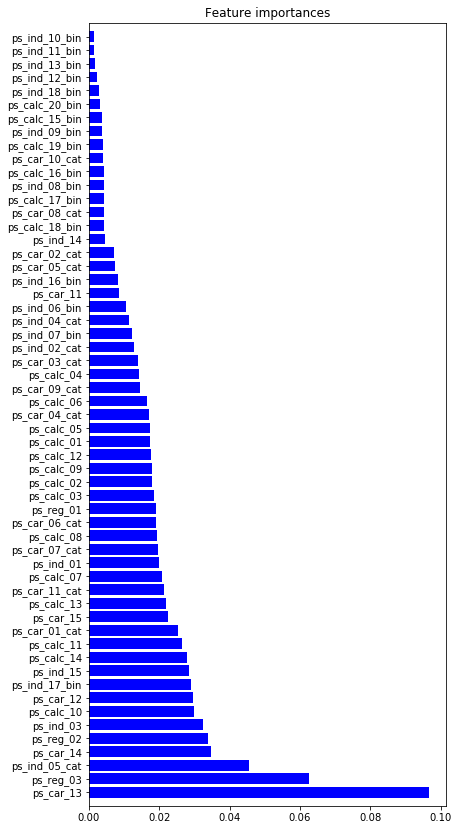

In [179]:
# Plot the feature importances of the RFC_all
import matplotlib.pyplot as plt
plt.figure(figsize=(6.4,4.8*3))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],
       color="b",  align="center")
plt.yticks(range(len(indices)), features_rank
          )
plt.ylim([-1, len(indices)])
plt.show()

In [204]:
# Remove the last 3 feaures in the rank
features_new = features_rank[:37]
print(features_new)

['ps_car_13', 'ps_reg_03', 'ps_ind_05_cat', 'ps_car_14', 'ps_reg_02', 'ps_ind_03', 'ps_calc_10', 'ps_car_12', 'ps_ind_17_bin', 'ps_ind_15', 'ps_calc_14', 'ps_calc_11', 'ps_car_01_cat', 'ps_car_15', 'ps_calc_13', 'ps_car_11_cat', 'ps_calc_07', 'ps_ind_01', 'ps_car_07_cat', 'ps_calc_08', 'ps_car_06_cat', 'ps_reg_01', 'ps_calc_03', 'ps_calc_02', 'ps_calc_09', 'ps_calc_12', 'ps_calc_01', 'ps_calc_05', 'ps_car_04_cat', 'ps_calc_06', 'ps_car_09_cat', 'ps_calc_04', 'ps_car_03_cat', 'ps_ind_02_cat', 'ps_ind_07_bin', 'ps_ind_04_cat', 'ps_ind_06_bin']


# Use new features to reconstruct the random forest

In [250]:
df_train = pd.read_csv(trainpath, index_col='id')


# According to https://www.kaggle.com/pnagel/reconstruction-of-ps-reg-03, 
# ps_reg_03=sqrt{I}/40

In [271]:
df_train["ps_reg_03"].apply(lambda x:(40*x)**2).head(10)

id
7      825.0
9      939.0
13    1600.0
16     540.0
17    1131.0
19    8706.0
20     610.0
22     590.0
26    1300.0
28    8587.0
Name: ps_reg_03, dtype: float64

In [251]:

target_train = df_train['target'].values # nparray

In [252]:
df_train = df_train.drop('target', axis = 1)

In [253]:
col_to_drop = df_train.columns[df_train.columns.str.startswith('ps_calc_')]
df_train = df_train.drop(col_to_drop, axis=1)  

In [254]:
len(df_train.columns.values)

37

In [255]:
def rfccv(n_estimators, max_features, max_depth):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            #min_samples_split=int(min_samples_split),
            max_features=int(max_features),
            max_depth=int(max_depth),
            random_state=None),
        df_train, target_train, scoring=gini_sklearnf, cv=3
    ).mean()
    return val

In [256]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,300),
         'max_features': (5,10),
         'max_depth': (1,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 06m39s |    0.24759 |      5.9008 |         9.3600 |       300.0000 | 
    2 | 10m10s |    0.26293 |      9.6546 |         8.5728 |       300.0000 | 
    3 | 03m14s |    0.23872 |      3.0748 |         6.8767 |       300.0000 | 
    4 | 07m21s |    0.26086 |      8.1039 |         6.1546 |       300.0000 | 
    5 | 04m16s |    0.24409 |      4.9800 |         7.7668 |       300.0000 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 07m33s |    0.26507 |     10.0000 |         5.0000 |       300.0000 | 
    7 | 06m47s |    0.26377 |     10.0000 |         5.0000 |       300.0000 | 
    8 | 12m45s |    0.26358 |     10.0000 |        10.0000 |       300.0000 | 
    9 | 05m19s | 

/Users/sue/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.17096492e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   11 | 07m25s |    0.26490 |     10.0000 |         5.0000 |       300.0000 | 
   12 | 03m28s |    0.24591 |      4.6892 |         5.3947 |       300.0000 | Warning: Test point chose at random due to repeated sample.

   13 | 09m50s |    0.26289 |      9.6269 |         8.9612 |       300.0000 | Warning: Test point chose at random due to repeated sample.

   14 | 06m57s |    0.26312 |     10.0000 |         5.0000 |       300.0000 | 
   15 | 07m02s |    0.26345 |     10.0000 |         5.0000 |       300.0000 | 
-----------------------------------------------------
Final Results
RFC: 0.265074


In [258]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,300),
         'max_features': (5,10),
         'max_depth': (5,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 07m05s |    0.26114 |      8.9479 |         6.8449 |       300.0000 | 
    2 | 06m29s |    0.24840 |      5.0448 |         9.4024 |       300.0000 | 
    3 | 04m42s |    0.24955 |      5.6957 |         6.0729 |       300.0000 | 
    4 | 07m02s |    0.25759 |      7.1245 |         7.0481 |       300.0000 | 
    5 | 05m14s |    0.24923 |      5.9049 |         7.3145 |       300.0000 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 11m48s |    0.26445 |     10.0000 |        10.0000 |       300.0000 | 
    7 | 06m48s |    0.26356 |     10.0000 |         5.0000 |       300.0000 | 
    8 | 11m45s |    0.26439 |     10.0000 |        10.0000 |       300.0000 | 
    9 | 06m48s | 

In [259]:
len(df_train.columns.values)

37

In [212]:
def rfccv(n_estimators, max_features, max_depth):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            #min_samples_split=int(min_samples_split),
            max_features=int(max_features),
            max_depth=int(max_depth),
            random_state=None),
        X_new, y_new, scoring=gini_sklearnf, cv=3
    ).mean()
    return val

In [213]:
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,301),
         'max_features': (5,10),
         'max_depth': (1,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 10m13s |    0.25472 |      7.7667 |         8.0283 |       300.2082 | 
    2 | 09m55s |    0.25098 |      6.4311 |         9.1895 |       300.6649 | 
    3 | 37m15s |    0.26055 |      9.9548 |         5.1825 |       300.1435 | 
    4 | 05m10s |    0.24857 |      5.0321 |         5.0399 |       300.8072 | 
    5 | 12m24s |    0.25722 |      8.2831 |         9.4554 |       300.6211 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 09m30s |    0.26019 |     10.0000 |         5.0000 |       301.0000 | 
    7 | 15m05s |    0.25915 |     10.0000 |        10.0000 |       301.0000 | 
    8 | 08m35s |    0.25892 |      9.9943 |         5.0011 |       300.0380 | 
    9 | 13m46s | 

In [215]:
import time

In [218]:
start = time.time()
if __name__ == "__main__":
    gp_params = {"alpha": 1e-5}

    rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (300,350),
         'max_features': (4,10),
         'max_depth': (1,10)
        }
    )

    rfcBO.maximize(n_iter=10, **gp_params)
    print('-' * 53)
    print('Final Results')
    #print('SVC: %f' % svcBO.res['max']['max_val'])
    print('RFC: %f' % rfcBO.res['max']['max_val'])
end = time.time()
runningtime = end - start
print('RunningTime={:.3f}'.format(runningtime))
print("-----------------------------------------------")

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    1 | 02m14s |    0.23186 |      2.4382 |         4.1232 |       317.3301 | 
    2 | 05m16s |    0.23563 |      3.8048 |         9.4540 |       301.9298 | 
    3 | 06m47s |    0.25715 |      8.1660 |         4.3365 |       303.5637 | 
    4 | 08m20s |    0.25802 |      8.6578 |         5.8150 |       314.2499 | 
    5 | 02m29s |    0.23436 |      2.6984 |         4.9551 |       342.1482 | 
Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   n_estimators | 
    6 | 17m11s |    0.25951 |      9.9216 |         9.8722 |       349.7595 | 
    7 | 08m48s |    0.25902 |     10.0000 |         4.0000 |       348.8200 | 
    8 | 07m39s |    0.25899 |      9.9345 |         4.0683 |       301.2087 | 
    9 | 18m28s | 

# Submission

In [126]:
subm = pd.DataFrame()
subm['id'] = df_test['id']
subm['target'] = y_test[:,1]

In [127]:
subm.head()

,id,target
0,0,0.026525
1,1,0.027268
2,2,0.033937
3,3,0.019153
4,4,0.035111


In [128]:
subm.to_csv('rfc_2.csv', index=False)

In [219]:
RFC_all

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=4, oob_score=False, random_state=2,
            verbose=True, warm_start=False)

# For stack

In [225]:
from sklearn.model_selection import StratifiedKFold, train_test_split
class Clf4Stack(object):
    def __init__(self, model, n_splits=5):
        self.n_splits = n_splits
        self.model = model

    def fit_predict(self, trainX, trainy, testX):

        self.train4stack = np.zeros(len(trainX))
        self.test4stack = np.zeros(len(testX))

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=44)

        for train_index, test_index in skf.split(trainX, trainy):
            X_train, X_test = trainX[train_index], trainX[test_index]
            y_train, y_test = trainy[train_index], trainy[test_index]

            self.model.fit(X_train, y_train)
            y_pred = self.model.predict_proba(X_test)[:,1]
            self.train4stack[test_index] = y_pred
            self.test4stack += self.model.predict_proba(testX)[:,1]
        
        self.test4stack /= self.n_splits
            
    def output(self,train_file_name='train4stack.csv',
                    test_file_name='test4stack.csv',
                    col_name='F4stack'):

        pd.DataFrame({col_name:self.train4stack}).to_csv(train_file_name,index=False) 
        pd.DataFrame({col_name:self.test4stack}).to_csv(test_file_name,index=False)

In [223]:
RFC_all

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=9, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=4, oob_score=False, random_state=2,
            verbose=True, warm_start=False)

In [222]:
X_all.shape

(595212, 57)

In [226]:
C4S=Clf4Stack(RFC_all)
C4S.fit_predict(X_all, y_all,df_test[features])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks    

In [227]:
C4S.output()

In [228]:
ls

Base model.ipynb
Base_model_SVM.ipynb
Base_model_random_forest.ipynb
Untitled.ipynb
bayesian_optimization_sklearn_example.py
data/
dummies_log.py
mubi_20171109/
mubi_20171112/
rfc.csv
rfc_1.csv
rfc_2.csv
test4stack.csv
train4stack.csv
